<div style="border-radius:10px;
            border : black solid;
            background-color: ##FFFFFF;
            font-size:160%;
            text-align: left">

<h1 style='; border:0; border-radius: 10px; text-shadow: 1px 1px black; font-weight: bold; color:#511A69'><center> CAR PRICES PREDICTION </center></h1>

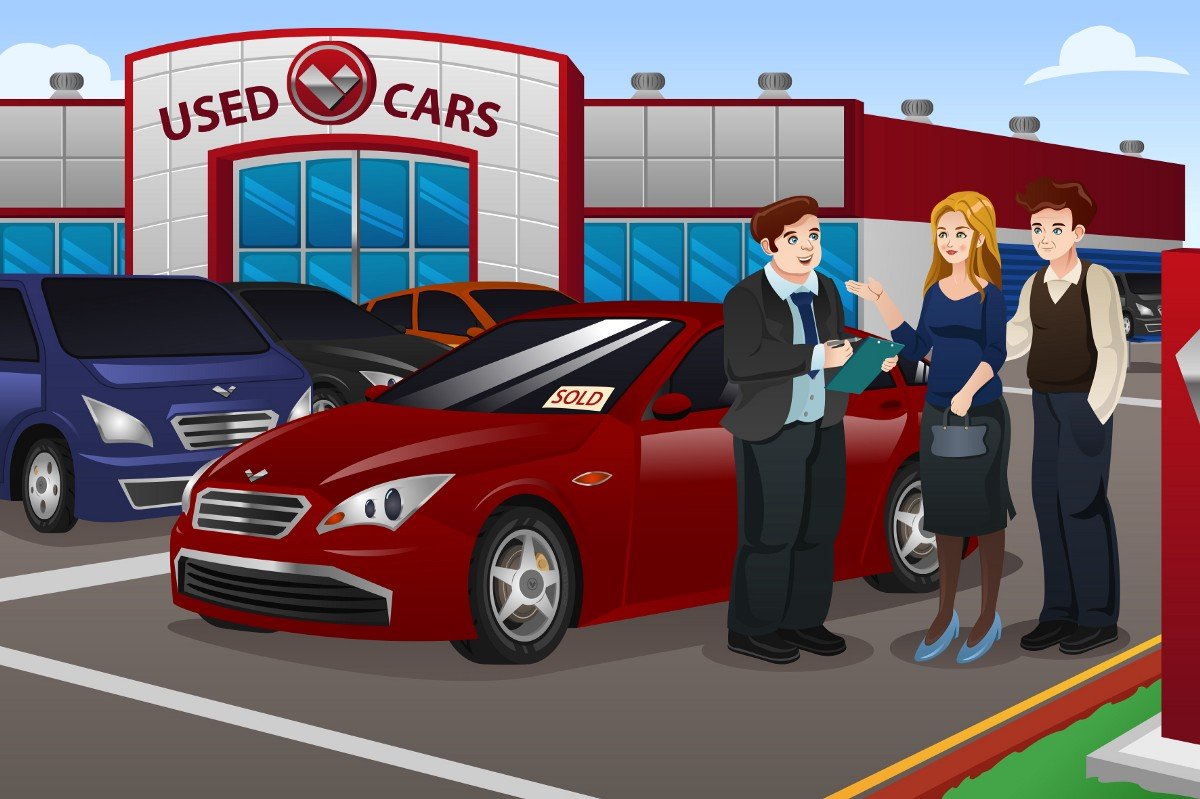

#### We have cardekho vechile dataset. This dataset conatin the information about used cars listed on cardekho website.
#### By using this data set we have to predict the selling price of cars

# Importing libraries

In [13]:
# importing important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import datetime

from scipy.stats import skew, norm

from sklearn.preprocessing import MinMaxScaler, RobustScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV,RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
import pickle

# to ignore warnings
import warnings 
warnings.filterwarnings('ignore')

# to see model hyperparameter
from sklearn import set_config
set_config(print_changed_only=False)

#to show all columns
pd.set_option('display.max_columns',None)

# Load the DataSet

In [14]:
car=pd.read_csv(r'Car details v3.csv')
car_df=car.copy()

 We have loaded the data set and created the copy of dataset

In [15]:
car_df.head(10).style.background_gradient(cmap='summer')

In [16]:
print(f'Number of rows are {car_df.shape[0]}\nNumber of columns are {car_df.shape[1]}' )


Number of rows are 8128
Number of columns are 13


## Exploratory Data Analysis

In [17]:
# check the meta data of dataset

car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


### Basic information about dataset
- There are 8128 rows and 13 columns
- There are 3 numerical and 10 categorical columns in data set
- There are null value in mileage, engine, max_power, torque and seats columns


In [18]:
# converting some object dtype in categorical dtype

categorical_col=['fuel','transmission','owner','seller_type']

for col in categorical_col:
    car_df[col]=car_df[col].astype('category')
    


In [19]:
# create brand_name feature from name

# pd.DataFrame(car_df['name'].str.split(' ').str).iloc[0,:]

car_df['brand_name']=car_df['name'].str.split().str[0]

car_df['brand_name']=car_df['brand_name'].astype('category')


# another way

#car_df["name"].str.extract('([^\s]+)')

- We have extracting out only the brand name from full name of vechile and storing it into brand_name column

In [20]:
# extracting the values of engine and mileage

car_df['engine']=car_df['engine'].str.split().str[0]
car_df['engine']=car_df['engine'].astype('float')

car_df['mileage']=car_df['mileage'].str.split().str[0]
car_df['mileage']=car_df['mileage'].astype('float')

- We are extracting only numerical values from engine column and mileage column

In [21]:
# extracting the max_power

car_df['max_power']=car_df['max_power'].str.split().str[0]
car_df['max_power']=car_df['max_power'][~(car_df['max_power']=='bhp')]
car_df['max_power']=car_df['max_power'].astype('float')

- We are extracting numerical value from max_power column
- There is one row where we have only 'bhp', we will drop this value

In [22]:
# create a feature car_age from year

car_df['car_age']=datetime.datetime.now().year-car_df['year']

- Here we are finding out the age of car by subratcting purchased year to current year and storing the value into age column

## Drop some columns that are not so much necessary

In [23]:
# drop the columns that are not necessary
car_df=car_df.drop(['name','year','torque'],axis=1)

In [24]:
car_df.head().style.background_gradient(cmap='summer')

In [25]:
# statistical analysis of dataset

car_df.describe().style.background_gradient(cmap='summer')

# Analysis of data set

- Minimum selling price is 29999 and the maximum selling price is 10000000
- The driven distance of least driven car is 1 km and tyhe driven distance of most driven car is 2360457
- Minimum mileage is 0 and maximum mileage is 42, and avg mileage is 19.418 
- The number of seats  changes from  2 to 14
- Oldest car is 40 year old and latest car is 3 year old

In [26]:
# statistical analysis of categorical datatype

car_df.describe(include='category')

fuel seller_type transmission        owner brand_name
count     8128        8128         8128         8128       8128
unique       4           3            2            5         32
top     Diesel  Individual       Manual  First Owner     Maruti
freq      4402        6766         7078         5289       2448

### Analysis of categorical datatypes
- Top selling brand is maruti with frequency : 2448
- Car with fuel type is in most demand with frequency : 4402
- Manual car are more in demand than automatic with frequency : 7708
- People are mostly liking to buy car from First owner: with frequency : 5289


### Checking null values

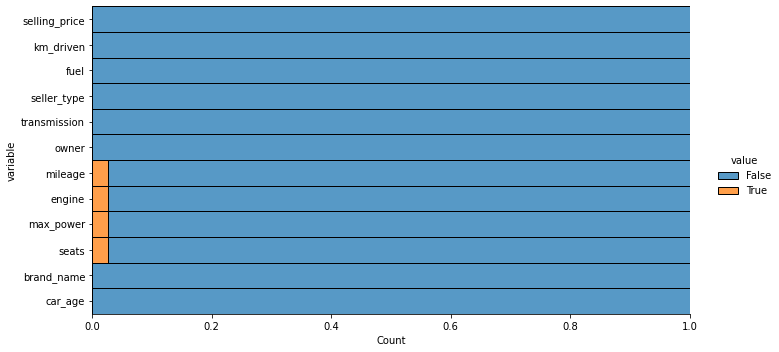

In [27]:
# vissualizing the missing values with seaborn 
sns.displot(data=car_df.isnull().melt(),y='variable',hue='value',
            multiple='fill',aspect=2)


<AxesSubplot: >

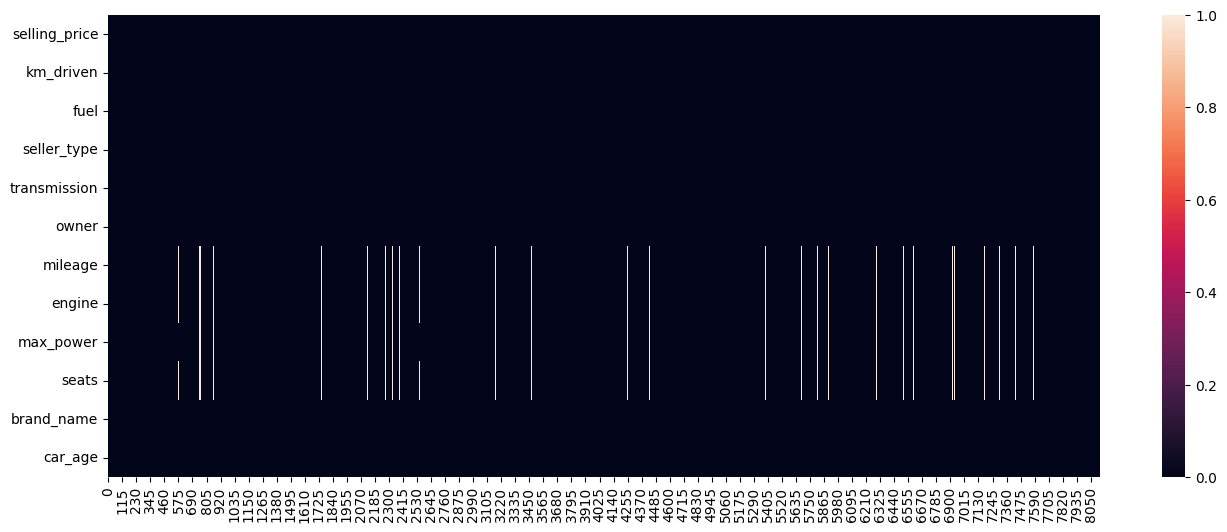

In [28]:
# visulasizing the null values with heatmap
plt.figure(figsize=(16,6))
sns.heatmap(car_df.isnull().T)

In [29]:
# fill the null values

num_col=[col for col in car_df if car_df[col].dtypes !='category']

cat_col=[col for col in car_df if car_df[col].dtypes == 'category']

# filling the missinng values of numerical data type with median

for col in num_col:
    car_df[col].fillna(car_df[col].median(),inplace =True)
    


# filling the missing values of categorical datatypes with mode 

for col in cat_col:
    car_df[col].fillna(car_df[col].mode(),inplace=True)



In [30]:
# check the null values in dataset
car_df.isnull().sum()

selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
seats            0
brand_name       0
car_age          0
dtype: int64

In [31]:
# count the values of each class in each categorical columns

lst=[]
for col in cat_col:
    a=car_df[col].value_counts()
    lst.append(a)
    
    
lst

[Diesel    4402
 Petrol    3631
 CNG         57
 LPG         38
 Name: fuel, dtype: int64,
 Individual          6766
 Dealer              1126
 Trustmark Dealer     236
 Name: seller_type, dtype: int64,
 Manual       7078
 Automatic    1050
 Name: transmission, dtype: int64,
 First Owner             5289
 Second Owner            2105
 Third Owner              555
 Fourth & Above Owner     174
 Test Drive Car             5
 Name: owner, dtype: int64,
 Maruti           2448
 Hyundai          1415
 Mahindra          772
 Tata              734
 Toyota            488
 Honda             467
 Ford              397
 Chevrolet         230
 Renault           228
 Volkswagen        186
 BMW               120
 Skoda             105
 Nissan             81
 Jaguar             71
 Volvo              67
 Datsun             65
 Mercedes-Benz      54
 Fiat               47
 Audi               40
 Lexus              34
 Jeep               31
 Mitsubishi         14
 Land                6
 Force           

In [32]:
# group by according to fuel
car_df.groupby(by='fuel').mean()

selling_price     km_driven    mileage       engine   max_power  \
fuel                                                                      
CNG     301017.491228  68288.438596  23.824211  1094.192982   62.835789   
Diesel  791452.921627  83677.137210  19.634607  1682.471831  101.034356   
LPG     200421.052632  89174.105263  18.634211  1047.605263   61.121053   
Petrol  462441.061691  52840.861746  19.088956  1184.449738   80.182952   

           seats    car_age  
fuel                         
CNG     5.017544   8.491228  
Diesel  5.711040   9.003408  
LPG     5.000000  13.368421  
Petrol  5.045167   9.396860

## Analysis
- Mean selling price of diesel car is highest with value of 791452.92
- Average mileage of CNG car is highest with value of 23.82


## Visualising the dataset

<AxesSubplot: xlabel='mileage'>

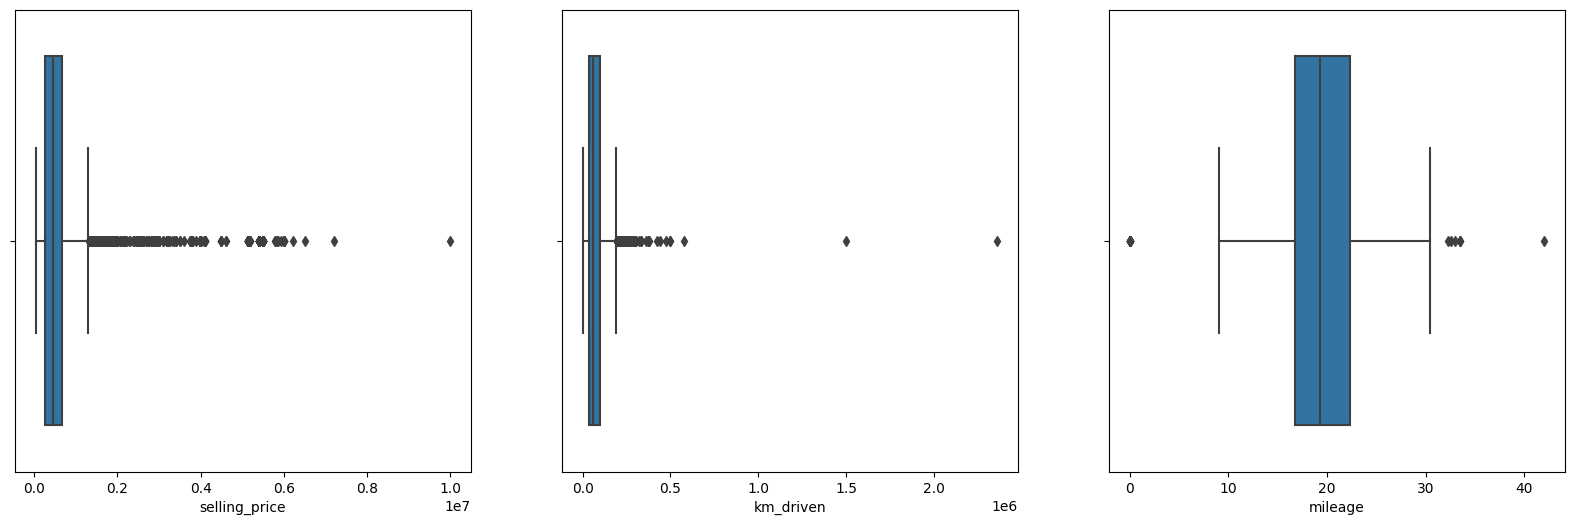

In [33]:
#Boxplot

fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,6))

sns.boxplot(ax=axes[0],x='selling_price',data=car_df)
sns.boxplot(ax=axes[1],x='km_driven',data=car_df)
sns.boxplot(ax=axes[2],x='mileage',data=car_df)


<AxesSubplot: xlabel='car_age'>

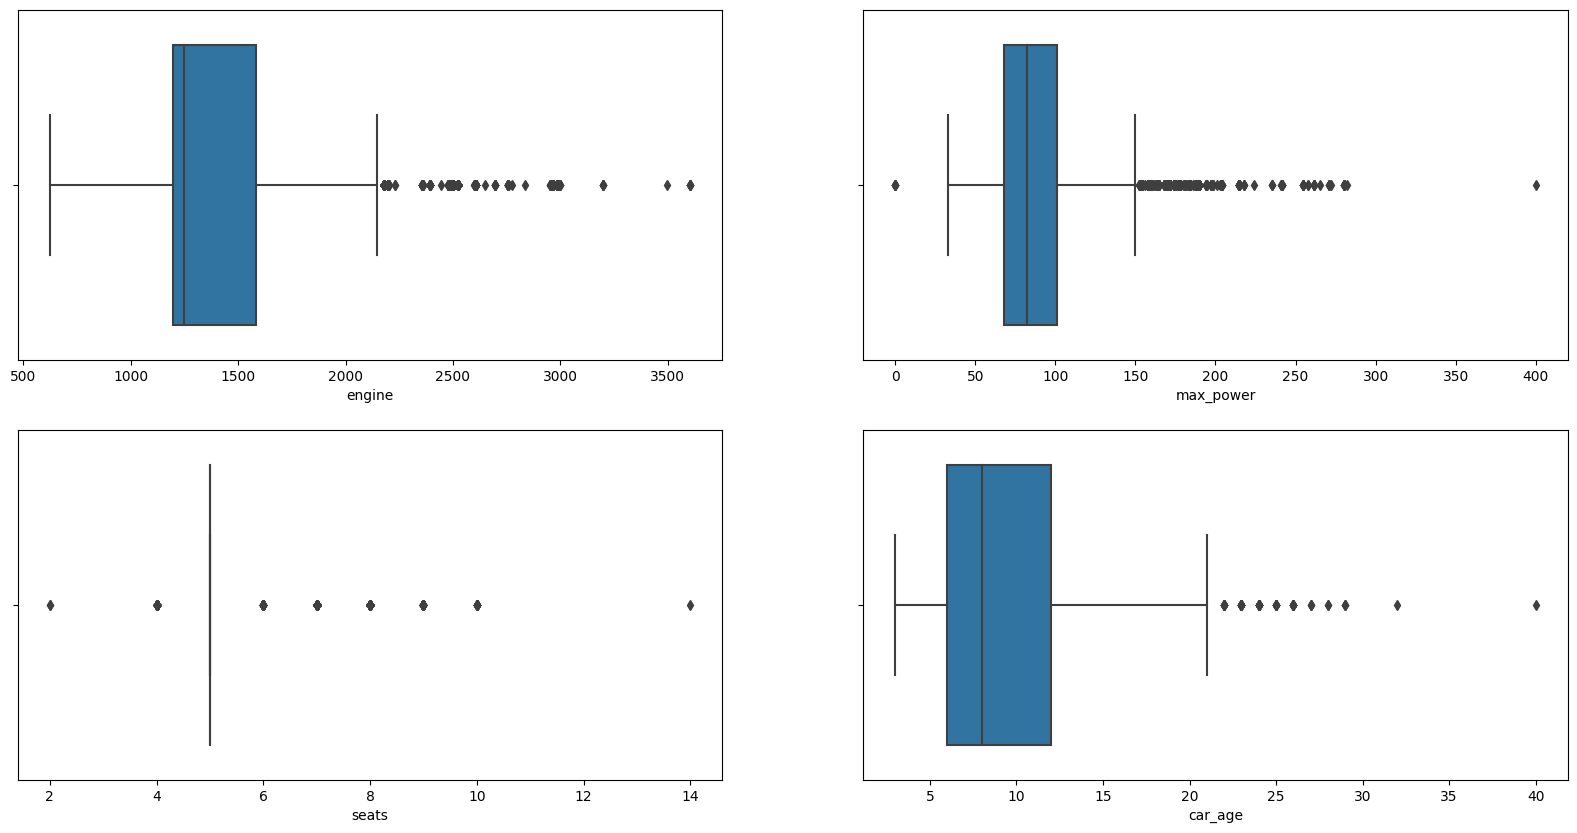

In [34]:
# boxplot

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(20,10))
axes=axes.flatten()

sns.boxplot(ax=axes[0],x='engine',data=car_df)
sns.boxplot(ax=axes[1],x='max_power',data=car_df)
sns.boxplot(ax=axes[2],x='seats',data=car_df)
sns.boxplot(ax=axes[3],x='car_age',data=car_df)

## Analysis of boxplot
- We can see there are some outliers are present sin our dataset

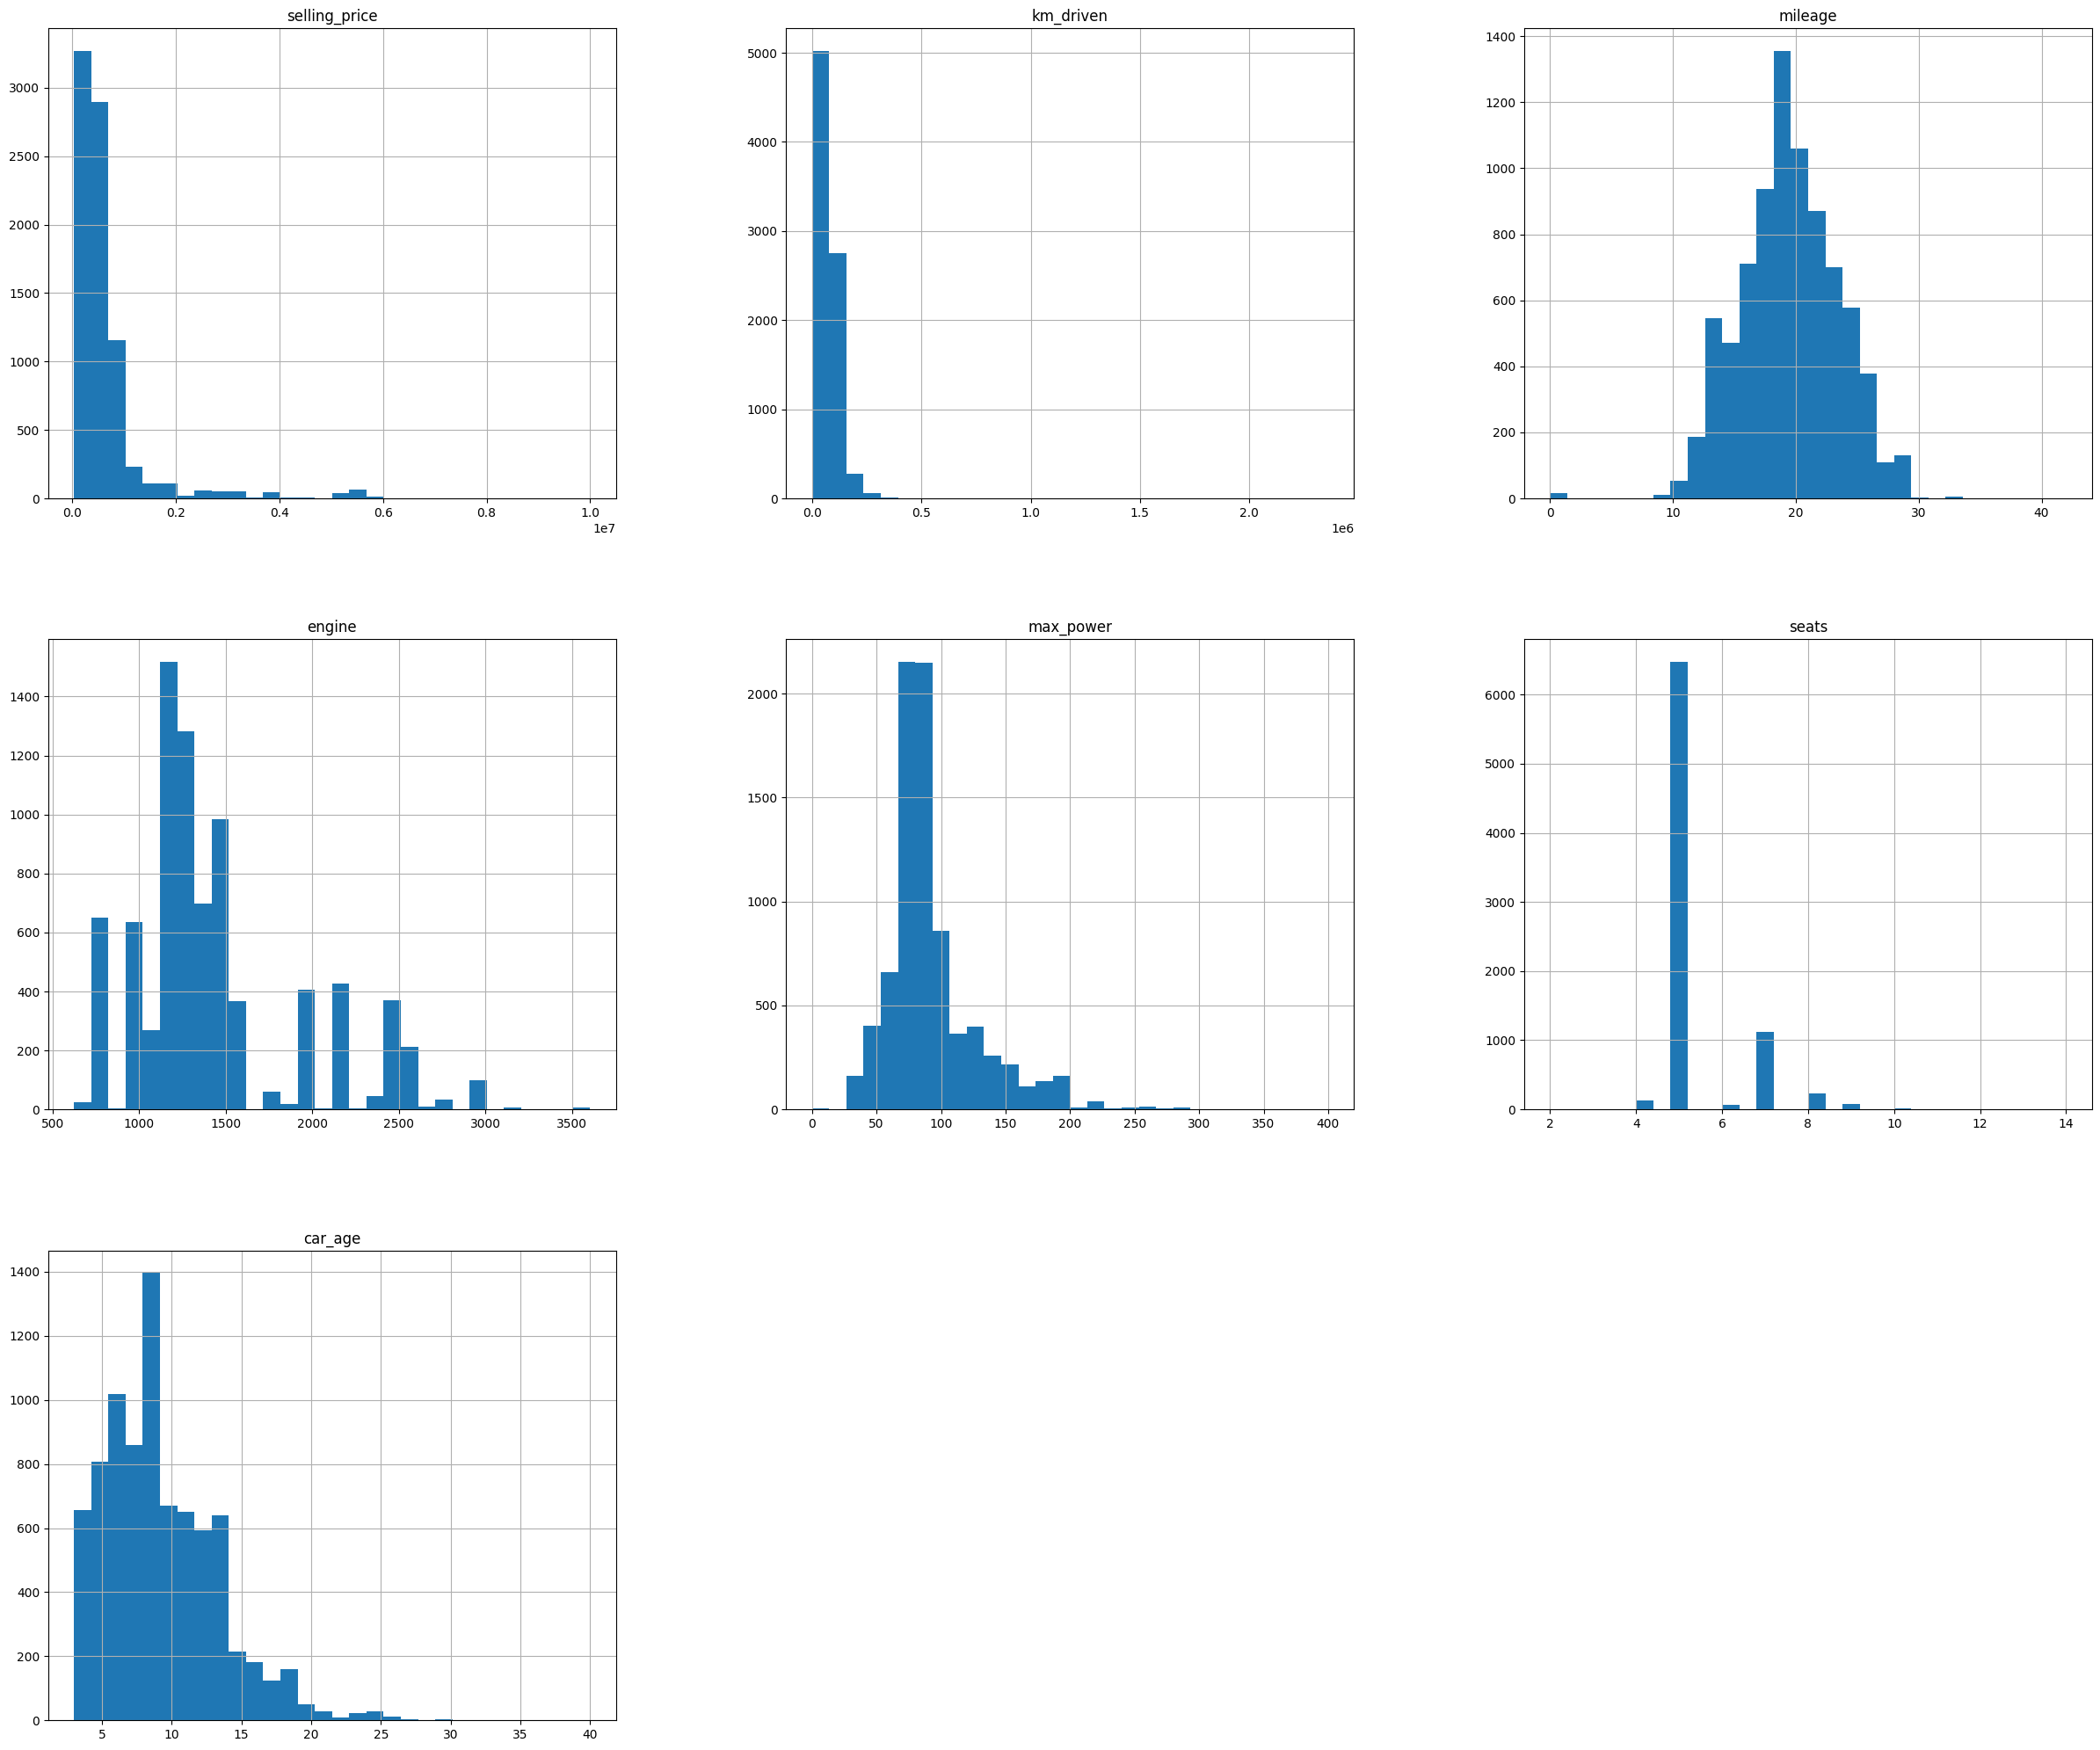

In [35]:
# plot the histogram

car_df.hist(figsize=(30,25),bins=30,legend=False)
plt.show()

## Analysis of histogram
### Distribution of columns

- Only mileage columns is following the normal distribution
- Other columns are somehow skewed

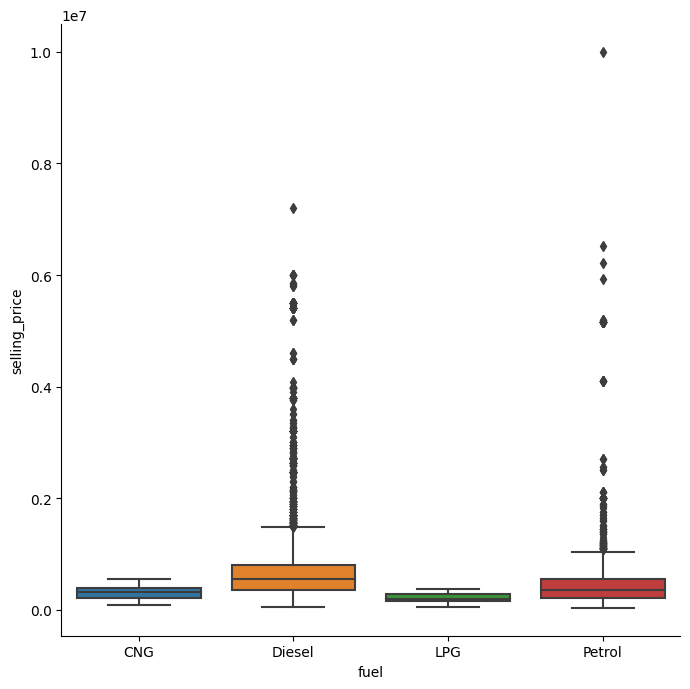

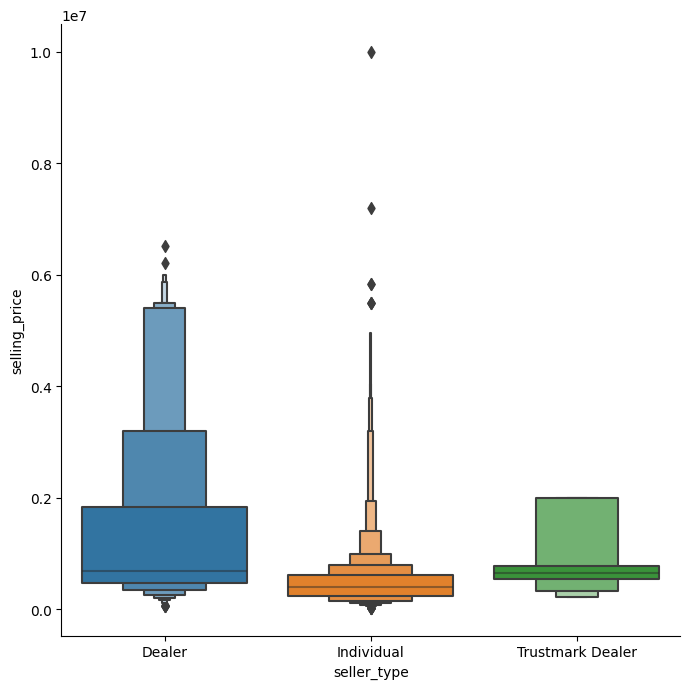

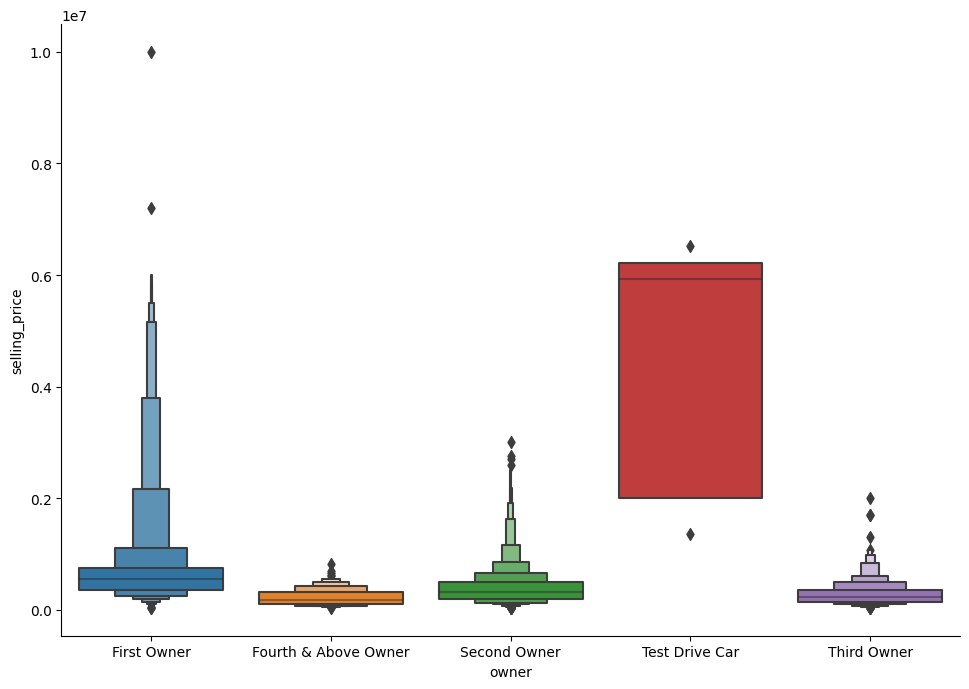

In [36]:
# ploting box plot

sns.catplot(x='fuel',y='selling_price',data=car_df,height=7,kind='box')
sns.catplot(x='seller_type',y='selling_price',kind='boxen',height=7,aspect=1,data=car_df)
sns.catplot(x='owner',y='selling_price',kind='boxen',height=7, aspect=1.4,data=car_df)

In [37]:
cat_col

['fuel', 'seller_type', 'transmission', 'owner', 'brand_name']

## Univarate Analysis

Text(0, 0.5, 'counts')

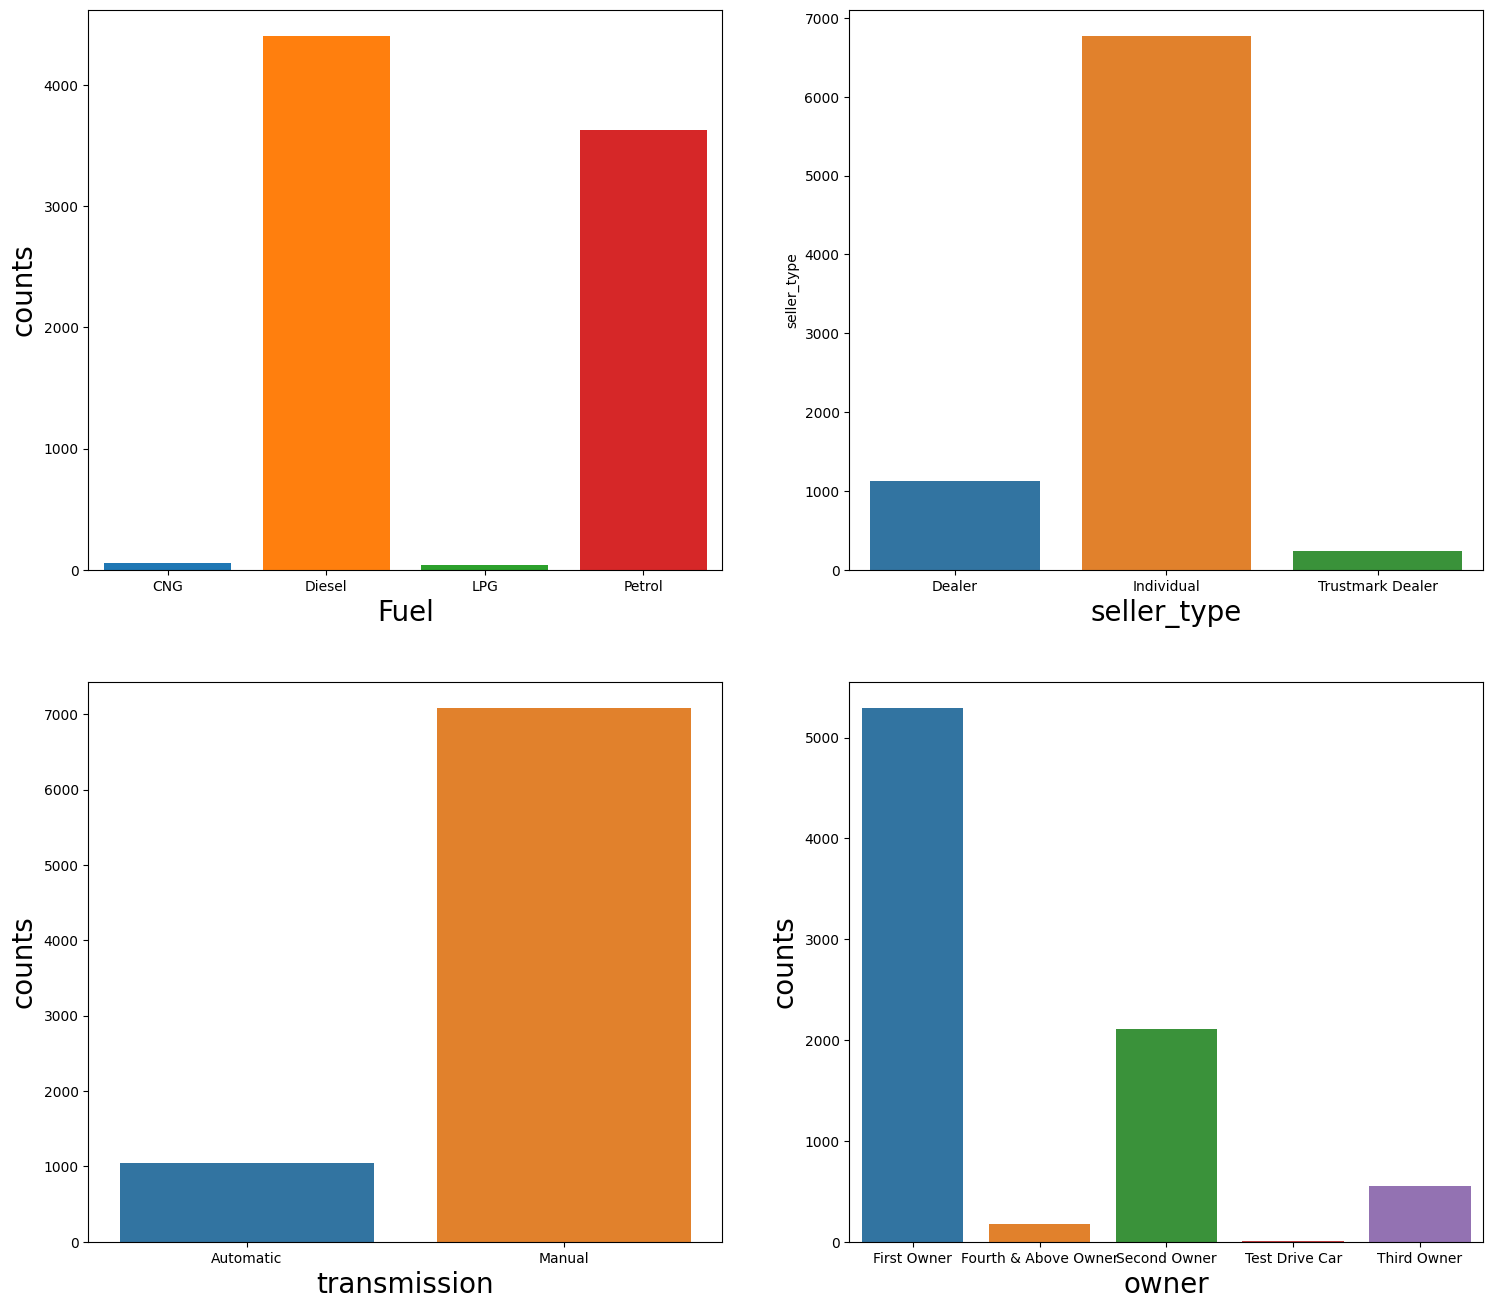

In [38]:
# barplot

fig,axes=plt.subplots(2,2,figsize=(18,16))
axes=axes.flatten()
sns.barplot(ax=axes[0],x=car_df['fuel'].value_counts().index,y=car_df['fuel'].value_counts(),saturation=1)
axes[0].set_xlabel('Fuel',fontsize=20)
axes[0].set_ylabel('counts',fontsize=20)
sns.barplot(ax=axes[1],x=car_df['seller_type'].value_counts().index,y=car_df['seller_type'].value_counts())
axes[1].set_xlabel('seller_type',fontsize=20)
axes[2].set_ylabel('counts',fontsize=20)
sns.barplot(ax=axes[2],x=car_df['transmission'].value_counts().index, y=car_df['transmission'].value_counts())
axes[2].set_xlabel('transmission',fontsize=20)
axes[2].set_ylabel('counts',fontsize=20)
sns.barplot(ax=axes[3],x=car_df['owner'].value_counts().index,y=car_df['owner'].value_counts())
axes[3].set_xlabel('owner',fontsize=20)
axes[3].set_ylabel('counts',fontsize=20)

In [39]:
car_df['fuel'].value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

# Analysis of barplot
### Fuel:-
- Number of diesel car is maximum 
- Number of CNG car minimum

### Seller_type
- Maximum car belongs to individual category
- Trustmark dealer has least number of cars

### Transmission
- Most of the cars belongs to manual category

### Owner
- Maximum car belongs to Firts_owner 
- Test Drive car category has least number of cars


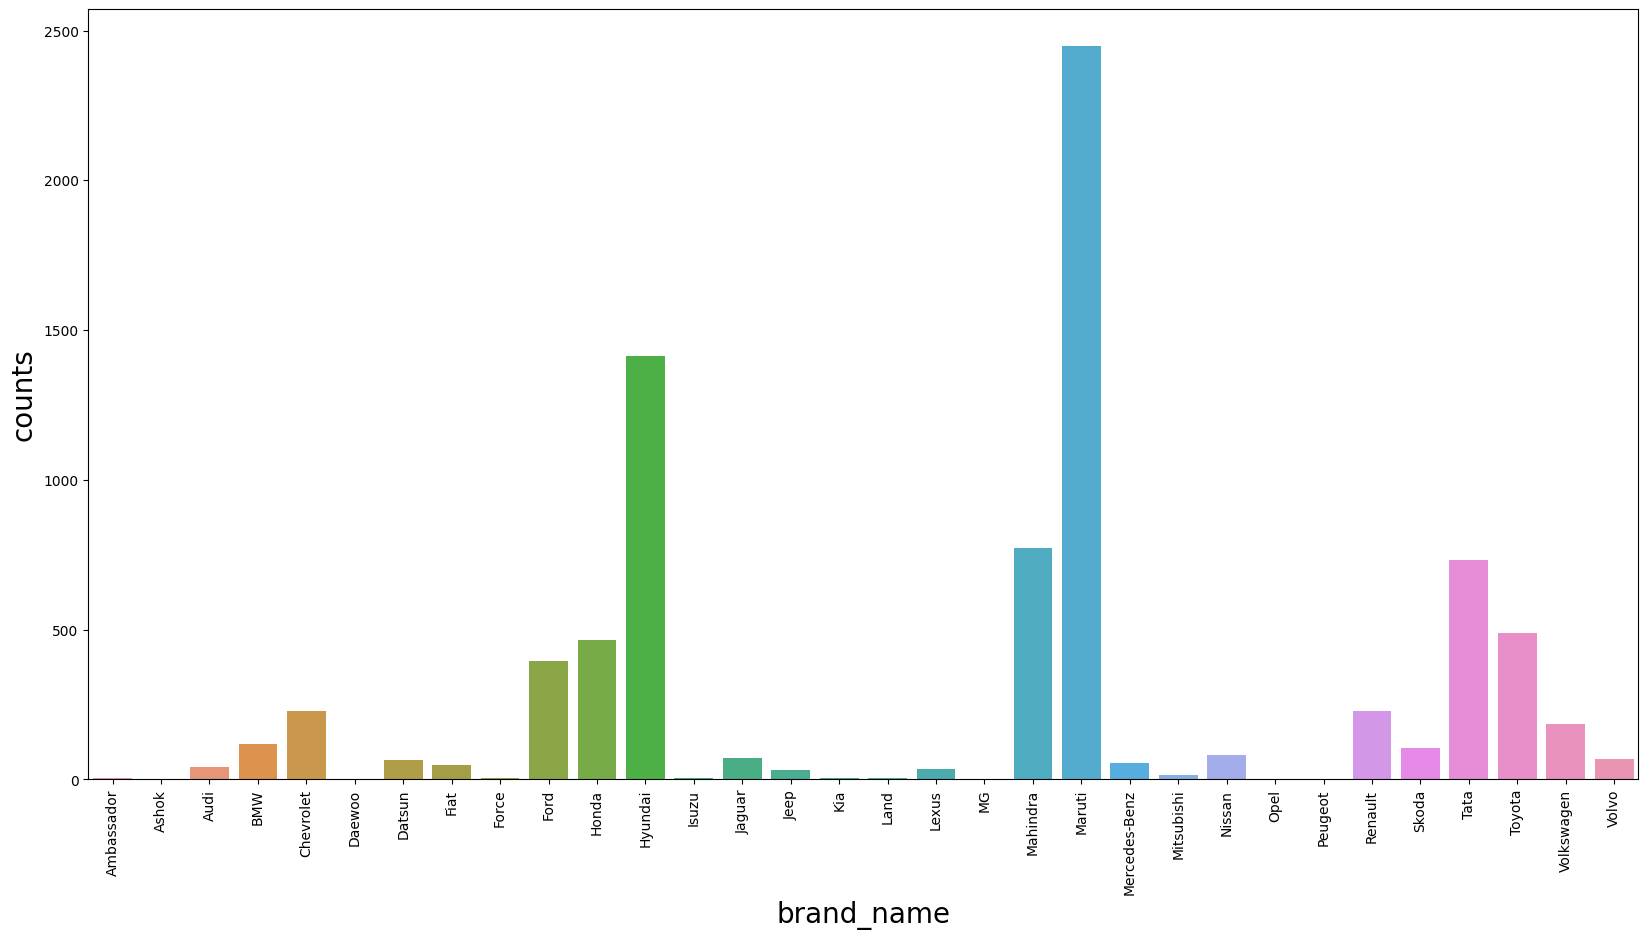

In [40]:
plt.figure(figsize=(20,10))
fig=sns.barplot(x=car_df['brand_name'].value_counts().index,y=car_df['brand_name'].value_counts())
fig.set_xlabel('brand_name',fontsize=20)
fig.set_ylabel('counts',fontsize=20)
plt.xticks(rotation=90)
plt.show()


## Analysis of bar plot
## Brand_name
- Maximum number of cars belong to Maruti brand followed by Hyundai
- Some brands like Opel, Pegueot, and Ashok has 1 car that is minimum


<AxesSubplot: ylabel='fuel'>

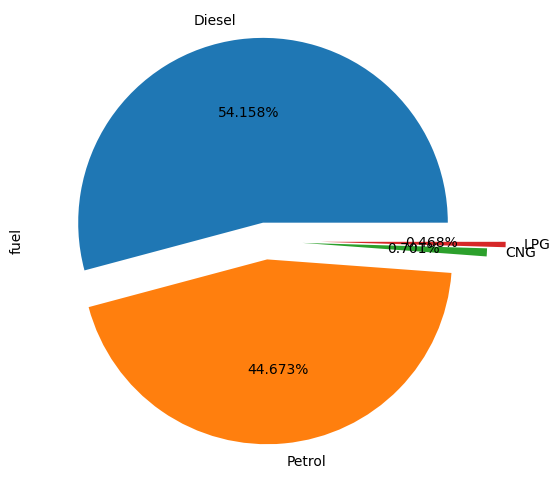

In [41]:
plt.figure(figsize=(10,6))
car_df['fuel'].value_counts().plot.pie(explode=[0.1,0.1,0.2,0.3],autopct='%1.3f%%')



## Analysis of pie plot
- Approximate 54.15% of cars use Diesel as fuel followed by petrol(44.67%)
- Very few cars only 0.4% use LPG as fuel and 0.7% of cars uses CNG as Fuel

# Multivariate Analysis

<AxesSubplot: xlabel='fuel', ylabel='selling_price'>

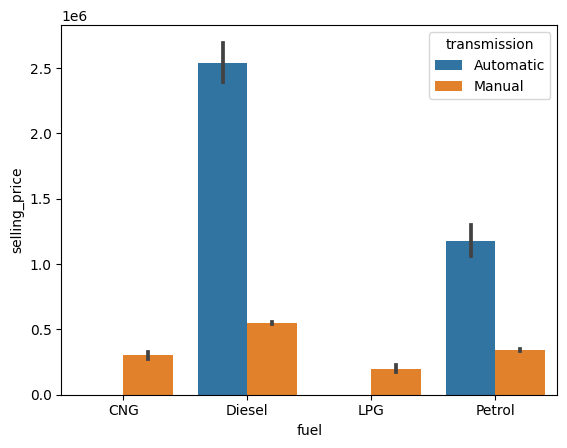

In [42]:
sns.barplot(x='fuel',y='selling_price',hue='transmission',data=car_df)

## Analysis of bar plot
-  Diesel car which have automatic gear transmission are most expensive.
- CNG and LPG category have only those cars which have manual gear transmission.
- LPG cars are less expensive than other categories

<AxesSubplot: xlabel='car_age', ylabel='selling_price'>

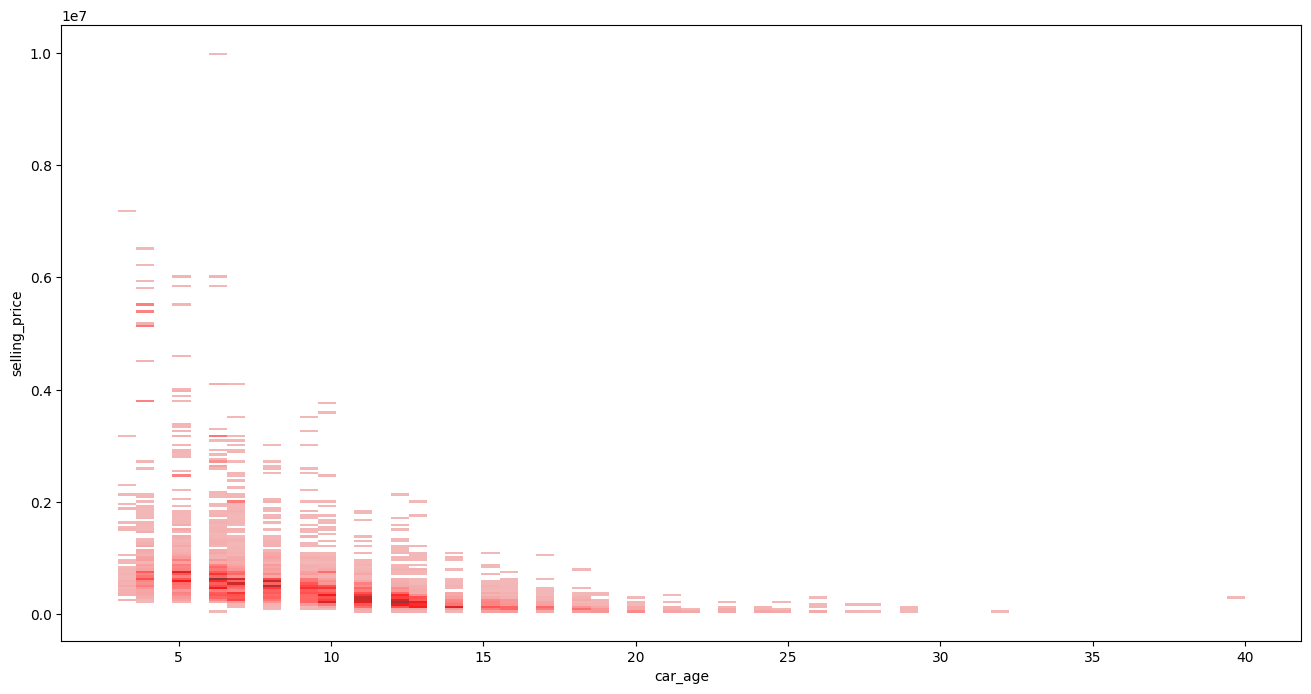

In [43]:

plt.figure(figsize=(16,8))
sns.histplot(x='car_age',y='selling_price', data=car_df,color='red')

## Analysis of histgram
- As the car is going to old the selling price is descresing.
- Old cars are less expensive than new cars

In [44]:
fig=px.histogram(car_df,x='car_age',y='selling_price',color='fuel',text_auto=True)
fig.show()

## Analysis of histogram  created using plotly
- As the care age is increasing the selling price is decreasing

In [45]:
fig=px.histogram(car_df,x='fuel',y='selling_price',color='owner',text_auto=True)
fig.show()

## Regression plot 
- Regression plot is used to find out the linear relationship
- It can be drawn for numerical columns
- We draw regression plot  to find out the relationship between feature column target column

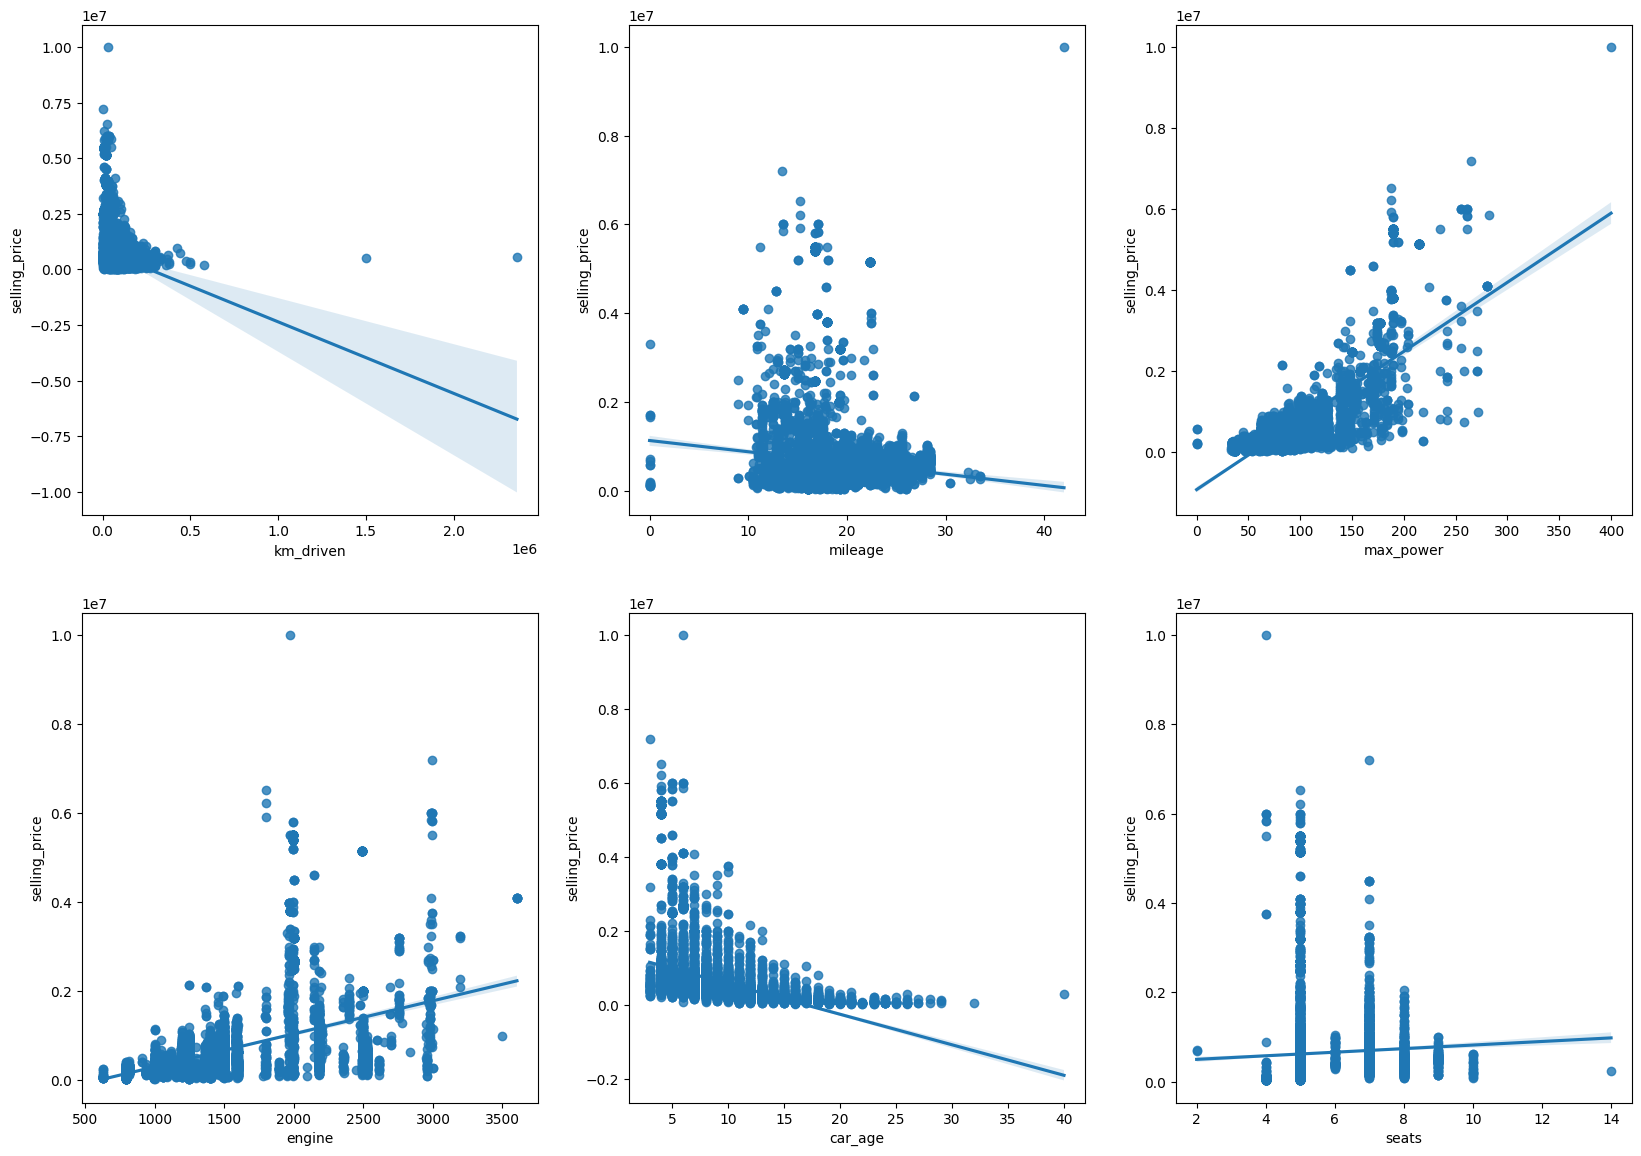

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

sns.regplot(ax = axes[0], x = "km_driven", y = "selling_price", data = car_df);
sns.regplot(ax = axes[1], x = "mileage", y = "selling_price", data = car_df);
sns.regplot(ax = axes[2], x = "max_power", y = "selling_price", data = car_df);
sns.regplot(ax = axes[3], x = "engine", y = "selling_price", data = car_df);
sns.regplot(ax = axes[4], x = "car_age", y = "selling_price", data = car_df);
sns.regplot(ax = axes[5], x = "seats", y = "selling_price", data = car_df);

## Analysis of regression plot
### km_driven
- Km_driven is negatively correlated with selling price
- It means more diven car are less expensive

### mileage
- There is norelationship between miloeage and seling_price

### max_power
- Max_power is positively correlated with selling_price
- As the max_power increases the selling price also increases

### engine
- Engine capicity is alos positively correlated with selling_price
- As the engine capacity increases the selling price also increases

### car_age
- car_age column is negatively correlated with selling pruice
- As the car_age increases the selling_price decreases

### seats
- There is no correlation between setas and selling price



<AxesSubplot: >

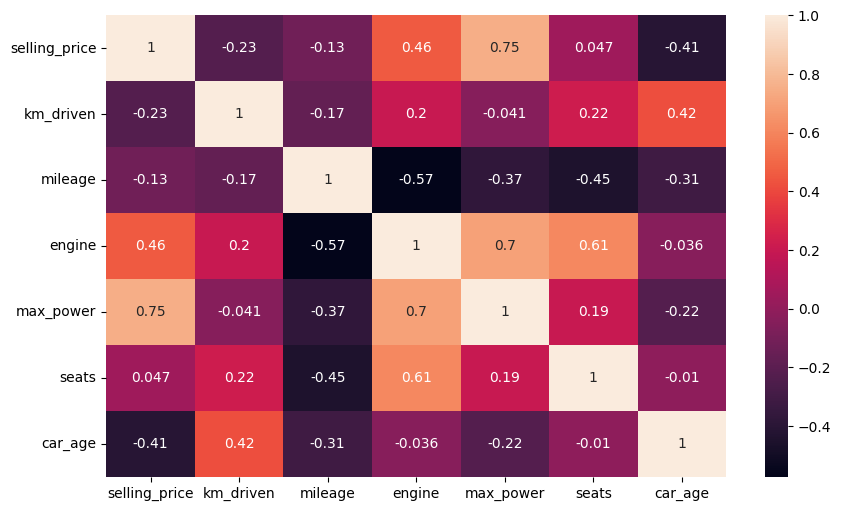

In [48]:
# correlation plot
plt.figure(figsize=(10,6))
sns.heatmap(car_df.corr(), annot=True)

## Correlation 
- Some columns are moderately correlated 
- The correlation :-
- between engine and mileage : -0.57
- between engine and max_power : 0.7
- between engine and setas : 0.61
- There is no multicollinearity in dataset because columns are not highly correlated

## Fix Skewness of the variables
- We have seen most of the variables(columns) are skewed
- So will fix the skewness by using log transformation

In [49]:
# skewness in target column

print('skewness :',car_df['selling_price'].skew())
print('kurtosis: ',car_df['selling_price'].kurt())

skewness : 4.193533440675855
kurtosis:  21.081289012186755


### Skewness and kurtosis analysis
- There is Positive Skewness it means there is tail in right side
- Kurtosis is greater tha 3 it means it is leptocurtic

<AxesSubplot: xlabel='selling_price', ylabel='Density'>

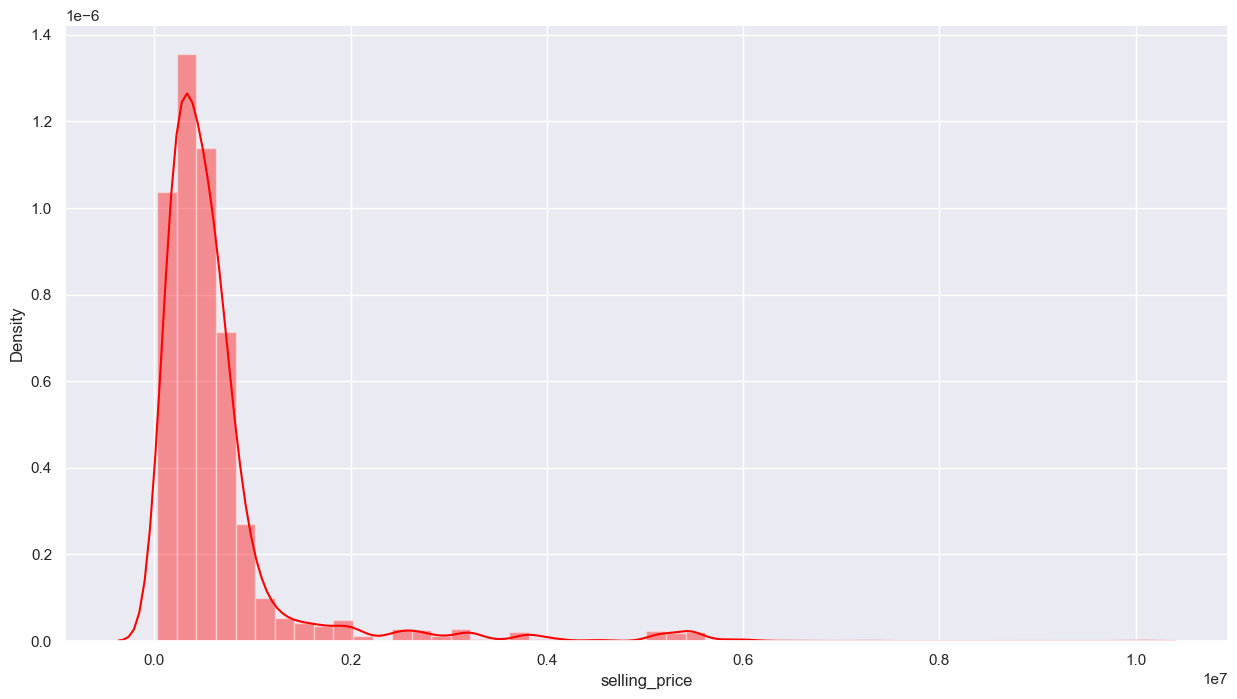

In [50]:
sns.set(rc={"figure.figsize":(15,8)})
sns.distplot(car_df['selling_price'],color='red')

- We can see the tail in right side of this graph .It is positively skewed 
- We will use log1p to fix it

<AxesSubplot: xlabel='selling_price', ylabel='Density'>

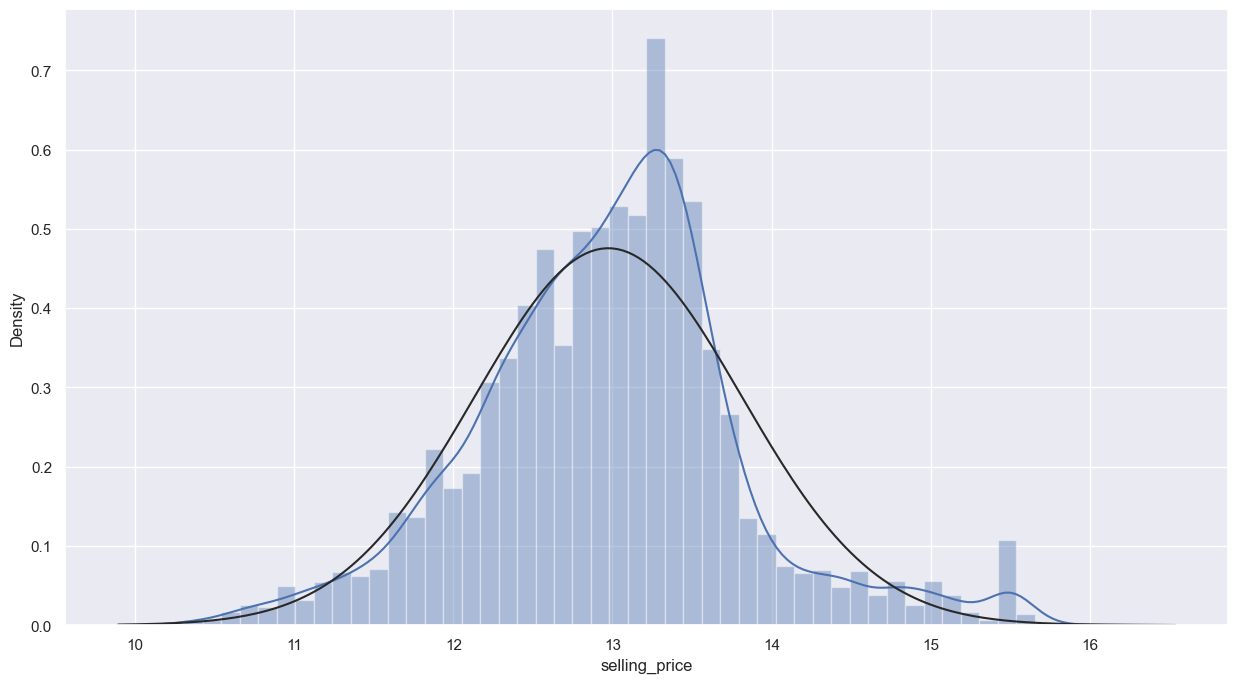

In [51]:
car_df['selling_price']=np.log1p(car_df['selling_price'])

sns.distplot(car_df['selling_price'],fit=norm)

- As we can see that we have fixed the skewness of target variable

In [52]:
# find the skewness of all feature columns

for col in num_col:
    print(f'skewness of {col} is ', car_df[col].skew())

skewness of selling_price is  0.22327004522860716
skewness of km_driven is  11.170909783549087
skewness of mileage is  -0.14220847114521287
skewness of engine is  1.1753055440141613
skewness of max_power is  1.6595575154307947
skewness of seats is  2.015507247545297
skewness of car_age is  1.072292893616034


In [53]:
# fix the skewness of other variable

for col in num_col:
    if col!='selling_price' and col != 'mileage':
        car_df[col]=np.log1p(car_df[col])

In [54]:
for col in num_col:
    print(f'skewness of {col} is ', car_df[col].skew())

skewness of selling_price is  0.22327004522860716
skewness of km_driven is  -1.2473957274807277
skewness of mileage is  -0.14220847114521287
skewness of engine is  0.4462500899554945
skewness of max_power is  -1.0068737857581982
skewness of seats is  1.6923972129414968
skewness of car_age is  0.10723690286174428


In [55]:
car_df.head()

selling_price  km_driven    fuel seller_type transmission         owner  \
0      13.017005  11.887938  Diesel  Individual       Manual   First Owner   
1      12.821261  11.695255  Diesel  Individual       Manual  Second Owner   
2      11.970357  11.849405  Petrol  Individual       Manual   Third Owner   
3      12.323860  11.751950  Diesel  Individual       Manual   First Owner   
4      11.775297  11.695255  Petrol  Individual       Manual   First Owner   

   mileage    engine  max_power     seats brand_name   car_age  
0    23.40  7.130099   4.317488  1.791759     Maruti  2.302585  
1    21.14  7.312553   4.649378  1.791759      Skoda  2.302585  
2    17.70  7.311886   4.369448  1.791759      Honda  2.890372  
3    23.00  7.242082   4.510860  1.791759    Hyundai  2.639057  
4    16.10  7.169350   4.490881  1.791759     Maruti  2.833213

## Split  the dataset

In [56]:
# spliting into features and target variable where x conatains features columns

x=car_df.drop('selling_price',axis=1)
y=car_df['selling_price']

In [57]:
x.shape, y.shape

((8128, 11), (8128,))

In [58]:
x

km_driven    fuel seller_type transmission                 owner  \
0     11.887938  Diesel  Individual       Manual           First Owner   
1     11.695255  Diesel  Individual       Manual          Second Owner   
2     11.849405  Petrol  Individual       Manual           Third Owner   
3     11.751950  Diesel  Individual       Manual           First Owner   
4     11.695255  Petrol  Individual       Manual           First Owner   
...         ...     ...         ...          ...                   ...   
8123  11.608245  Petrol  Individual       Manual           First Owner   
8124  11.686887  Diesel  Individual       Manual  Fourth & Above Owner   
8125  11.695255  Diesel  Individual       Manual           First Owner   
8126  10.126671  Diesel  Individual       Manual           First Owner   
8127  10.126671  Diesel  Individual       Manual           First Owner   

      mileage    engine  max_power     seats brand_name   car_age  
0       23.40  7.130099   4.317488  1.791759     Maruti  2.302585  
1       21.14  7.312553   4.649378  1.791759      Skoda  2.302585  
2       17.70  7.311886   4.369448  1.791759      Honda  2.890372  
3       23.00  7.242082   4.510860  1.791759    Hyundai  2.639057  
4       16.10  7.169350   4.490881  1.791759     Maruti  2.833213  
...       ...       ...        ...       ...        ...       ...  
8123    18.50  7.088409   4.429029  1.791759    Hyundai  2.397895  
8124    16.80  7.309212   4.709530  1.791759    Hyundai  2.833213  
8125    19.30  7.130099   4.316154  1.791759     Maruti  2.708050  
8126    23.57  7.242082   4.262680  1.791759       Tata  2.397895  
8127    23.57  7.242082   4.262680  1.791759       Tata  2.397895  

[8128 rows x 11 columns]

## Encode the categorical data

In [59]:
ohe=OneHotEncoder(drop='first')
feature_array=ohe.fit_transform(x[['fuel','seller_type','transmission','owner','brand_name']]).toarray()
feature_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [60]:
ohe.categories_

[array(['CNG', 'Diesel', 'LPG', 'Petrol'], dtype=object),
 array(['Dealer', 'Individual', 'Trustmark Dealer'], dtype=object),
 array(['Automatic', 'Manual'], dtype=object),
 array(['First Owner', 'Fourth & Above Owner', 'Second Owner',
        'Test Drive Car', 'Third Owner'], dtype=object),
 array(['Ambassador', 'Ashok', 'Audi', 'BMW', 'Chevrolet', 'Daewoo',
        'Datsun', 'Fiat', 'Force', 'Ford', 'Honda', 'Hyundai', 'Isuzu',
        'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus', 'MG', 'Mahindra',
        'Maruti', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Opel',
        'Peugeot', 'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen',
        'Volvo'], dtype=object)]

In [61]:
feature_labels=ohe.categories_

labels=[]
for i in feature_labels:
        for j in i:
            if j!=i[0]:
                labels.append(j)
                
labels



['Diesel',
 'LPG',
 'Petrol',
 'Individual',
 'Trustmark Dealer',
 'Manual',
 'Fourth & Above Owner',
 'Second Owner',
 'Test Drive Car',
 'Third Owner',
 'Ashok',
 'Audi',
 'BMW',
 'Chevrolet',
 'Daewoo',
 'Datsun',
 'Fiat',
 'Force',
 'Ford',
 'Honda',
 'Hyundai',
 'Isuzu',
 'Jaguar',
 'Jeep',
 'Kia',
 'Land',
 'Lexus',
 'MG',
 'Mahindra',
 'Maruti',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Opel',
 'Peugeot',
 'Renault',
 'Skoda',
 'Tata',
 'Toyota',
 'Volkswagen',
 'Volvo']

In [62]:
df1=pd.DataFrame(feature_array,columns=labels)
df1.head()

Diesel  LPG  Petrol  Individual  Trustmark Dealer  Manual  \
0     1.0  0.0     0.0         1.0               0.0     1.0   
1     1.0  0.0     0.0         1.0               0.0     1.0   
2     0.0  0.0     1.0         1.0               0.0     1.0   
3     1.0  0.0     0.0         1.0               0.0     1.0   
4     0.0  0.0     1.0         1.0               0.0     1.0   

   Fourth & Above Owner  Second Owner  Test Drive Car  Third Owner  Ashok  \
0                   0.0           0.0             0.0          0.0    0.0   
1                   0.0           1.0             0.0          0.0    0.0   
2                   0.0           0.0             0.0          1.0    0.0   
3                   0.0           0.0             0.0          0.0    0.0   
4                   0.0           0.0             0.0          0.0    0.0   

   Audi  BMW  Chevrolet  Daewoo  Datsun  Fiat  Force  Ford  Honda  Hyundai  \
0   0.0  0.0        0.0     0.0     0.0   0.0    0.0   0.0    0.0      0.0   
1   0.0  0.0        0.0     0.0     0.0   0.0    0.0   0.0    0.0      0.0   
2   0.0  0.0        0.0     0.0     0.0   0.0    0.0   0.0    1.0      0.0   
3   0.0  0.0        0.0     0.0     0.0   0.0    0.0   0.0    0.0      1.0   
4   0.0  0.0        0.0     0.0     0.0   0.0    0.0   0.0    0.0      0.0   

   Isuzu  Jaguar  Jeep  Kia  Land  Lexus   MG  Mahindra  Maruti  \
0    0.0     0.0   0.0  0.0   0.0    0.0  0.0       0.0     1.0   
1    0.0     0.0   0.0  0.0   0.0    0.0  0.0       0.0     0.0   
2    0.0     0.0   0.0  0.0   0.0    0.0  0.0       0.0     0.0   
3    0.0     0.0   0.0  0.0   0.0    0.0  0.0       0.0     0.0   
4    0.0     0.0   0.0  0.0   0.0    0.0  0.0       0.0     1.0   

   Mercedes-Benz  Mitsubishi  Nissan  Opel  Peugeot  Renault  Skoda  Tata  \
0            0.0         0.0     0.0   0.0      0.0      0.0    0.0   0.0   
1            0.0         0.0     0.0   0.0      0.0      0.0    1.0   0.0   
2            0.0         0.0     0.0   0.0      0.0      0.0    0.0   0.0   
3            0.0         0.0     0.0   0.0      0.0      0.0    0.0   0.0   
4            0.0         0.0     0.0   0.0      0.0      0.0    0.0   0.0   

   Toyota  Volkswagen  Volvo  
0     0.0         0.0    0.0  
1     0.0         0.0    0.0  
2     0.0         0.0    0.0  
3     0.0         0.0    0.0  
4     0.0         0.0    0.0

In [63]:
# save the onehotencoder

file_name='one_hot_encoder.pkl'
one_hot_encoder=pickle.dump(ohe,open(file_name,'wb'))

In [64]:
x=pd.concat([x,df1],axis=1)

In [65]:
x=x.drop(columns=['fuel','seller_type','transmission','owner','brand_name'])

In [66]:
x.head()

km_driven  mileage    engine  max_power     seats   car_age  Diesel  LPG  \
0  11.887938    23.40  7.130099   4.317488  1.791759  2.302585     1.0  0.0   
1  11.695255    21.14  7.312553   4.649378  1.791759  2.302585     1.0  0.0   
2  11.849405    17.70  7.311886   4.369448  1.791759  2.890372     0.0  0.0   
3  11.751950    23.00  7.242082   4.510860  1.791759  2.639057     1.0  0.0   
4  11.695255    16.10  7.169350   4.490881  1.791759  2.833213     0.0  0.0   

   Petrol  Individual  Trustmark Dealer  Manual  Fourth & Above Owner  \
0     0.0         1.0               0.0     1.0                   0.0   
1     0.0         1.0               0.0     1.0                   0.0   
2     1.0         1.0               0.0     1.0                   0.0   
3     0.0         1.0               0.0     1.0                   0.0   
4     1.0         1.0               0.0     1.0                   0.0   

   Second Owner  Test Drive Car  Third Owner  Ashok  Audi  BMW  Chevrolet  \
0           0.0             0.0          0.0    0.0   0.0  0.0        0.0   
1           1.0             0.0          0.0    0.0   0.0  0.0        0.0   
2           0.0             0.0          1.0    0.0   0.0  0.0        0.0   
3           0.0             0.0          0.0    0.0   0.0  0.0        0.0   
4           0.0             0.0          0.0    0.0   0.0  0.0        0.0   

   Daewoo  Datsun  Fiat  Force  Ford  Honda  Hyundai  Isuzu  Jaguar  Jeep  \
0     0.0     0.0   0.0    0.0   0.0    0.0      0.0    0.0     0.0   0.0   
1     0.0     0.0   0.0    0.0   0.0    0.0      0.0    0.0     0.0   0.0   
2     0.0     0.0   0.0    0.0   0.0    1.0      0.0    0.0     0.0   0.0   
3     0.0     0.0   0.0    0.0   0.0    0.0      1.0    0.0     0.0   0.0   
4     0.0     0.0   0.0    0.0   0.0    0.0      0.0    0.0     0.0   0.0   

   Kia  Land  Lexus   MG  Mahindra  Maruti  Mercedes-Benz  Mitsubishi  Nissan  \
0  0.0   0.0    0.0  0.0       0.0     1.0            0.0         0.0     0.0   
1  0.0   0.0    0.0  0.0       0.0     0.0            0.0         0.0     0.0   
2  0.0   0.0    0.0  0.0       0.0     0.0            0.0         0.0     0.0   
3  0.0   0.0    0.0  0.0       0.0     0.0            0.0         0.0     0.0   
4  0.0   0.0    0.0  0.0       0.0     1.0            0.0         0.0     0.0   

   Opel  Peugeot  Renault  Skoda  Tata  Toyota  Volkswagen  Volvo  
0   0.0      0.0      0.0    0.0   0.0     0.0         0.0    0.0  
1   0.0      0.0      0.0    1.0   0.0     0.0         0.0    0.0  
2   0.0      0.0      0.0    0.0   0.0     0.0         0.0    0.0  
3   0.0      0.0      0.0    0.0   0.0     0.0         0.0    0.0  
4   0.0      0.0      0.0    0.0   0.0     0.0         0.0    0.0

In [67]:
x.shape

(8128, 47)

In [68]:
# spliting the data into training ansd testing dataset

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,shuffle=True,random_state=1)

print(x_train.shape)
print(x_test.shape)

(6096, 47)
(2032, 47)


## Normalize the data

In [69]:
rob_scaler=RobustScaler()
x_train_scaled=rob_scaler.fit_transform(x_train)
x_test_scaled=rob_scaler.transform(x_test)

## Model taining

#### Define the cross validation metrics

In [70]:
kfold=KFold(n_splits=10,shuffle=True,random_state=1)

### Building the model

In [71]:
xgb=XGBRegressor(n_estimators=100,random_state=1)
lgb=LGBMRegressor(n_estimators=100,random_state=1)
gbr=GradientBoostingRegressor(n_estimators=100,random_state=1)
rf=RandomForestRegressor(n_estimators=100,random_state=1)
svr=SVR(C=20)
lasso=LassoCV(alphas=[0.00001,0.00003,0.004,0.2,0.5,0.7,1,3,5],n_jobs=-1,cv=kfold)

stacked=StackingCVRegressor(regressors=(xgb,lgb,gbr,rf,svr,lasso),meta_regressor=xgb,
                           use_features_in_secondary=True)

In [72]:
models={'linear_regression':LinearRegression(),
        'xgb':XGBRegressor(n_estimators=100,random_state=1),
       'lgb':LGBMRegressor(n_estimators=100,random_state=1),
       'gbr':GradientBoostingRegressor(n_estimators=100,random_state=1),
       'random_forest':RandomForestRegressor(n_estimators=100,random_state=1),
       'svr':SVR(C=20)}

In [82]:
for name,clf in models.items():
    model=clf.fit(x_train_scaled,y_train)
    y_pred=np.expm1(model.predict(x_test_scaled))
    cv_score=cross_val_score(model,x_train_scaled,y_train,cv=kfold)
    r2= r2_score(np.expm1(y_test),y_pred)
    print(f'\ncv_score for {name} is ', cv_score.mean())
    print(f'R2 score for {name} is ', r2)
    


cv_score for linear_regression is  0.8957244166068232
R2 score for linear_regression is  0.9386066670537222

cv_score for xgb is  0.939432633772712
R2 score for xgb is  0.9749737294442647

cv_score for lgb is  0.9399586152772533
R2 score for lgb is  0.9722963896396296

cv_score for gbr is  0.9291636823862278
R2 score for gbr is  0.9625053310111239

cv_score for random_forest is  0.9361603454296429
R2 score for random_forest is  0.9714716444225715

cv_score for svr is  0.9304285464696023
R2 score for svr is  0.9618568408294532


- As we can xgb is giving us the best result, so we will select this model as final model
- The r2 score of xgb is 93.8%

## XGB Regression model

In [74]:
xgb=XGBRegressor(n_estimators=100,random_state=1)
xgb.fit(x_train_scaled,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=1, reg_alpha=0, ...)

In [75]:
# we have used log1p on selling_price columns
# Now to gain the values back in original range we have to use exponential(expm1)

y_pred=xgb.predict(x_test_scaled)
y_pred=np.expm1(y_pred)
y_pred

array([ 214578.56, 1339602.8 ,  782603.  , ..., 1906738.1 , 1518326.5 ,
       1421207.2 ], dtype=float32)

In [76]:
# save the model

file_name='model.pkl'
model=pickle.dump(xgb,open(file_name,'wb'))

# Performance of model

In [77]:
# preformance of xgb model
print('mean_squared_error: ',mean_squared_error(np.expm1(y_test),y_pred))
print('mean_absolute_error: ',mean_absolute_error(np.expm1(y_test),y_pred))
print('rmse: ',np.sqrt(mean_squared_error(np.expm1(y_test),y_pred)))

mean_squared_error:  14592813999.999641
mean_absolute_error:  62781.22287347752
rmse:  120800.72019652715


In [78]:
# check r2 score
r2_score(np.expm1(y_test),y_pred)

0.9749737294442647

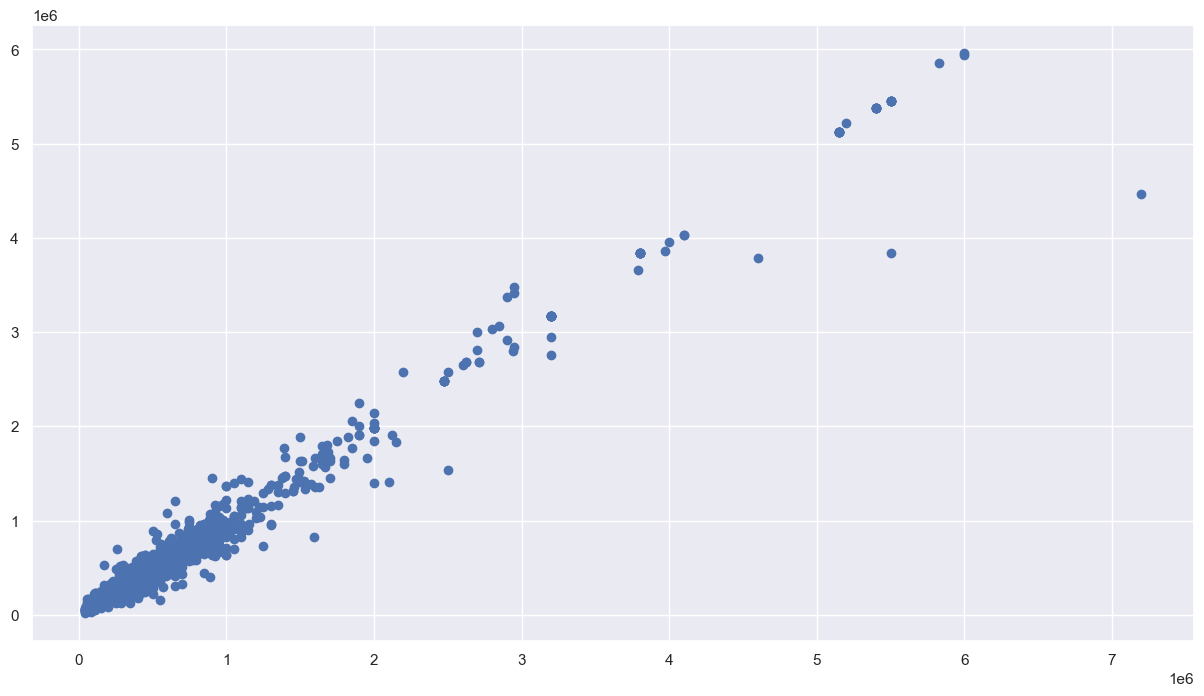

In [79]:
plt.scatter(np.expm1(y_test), y_pred)

<AxesSubplot: xlabel='selling_price', ylabel='Density'>

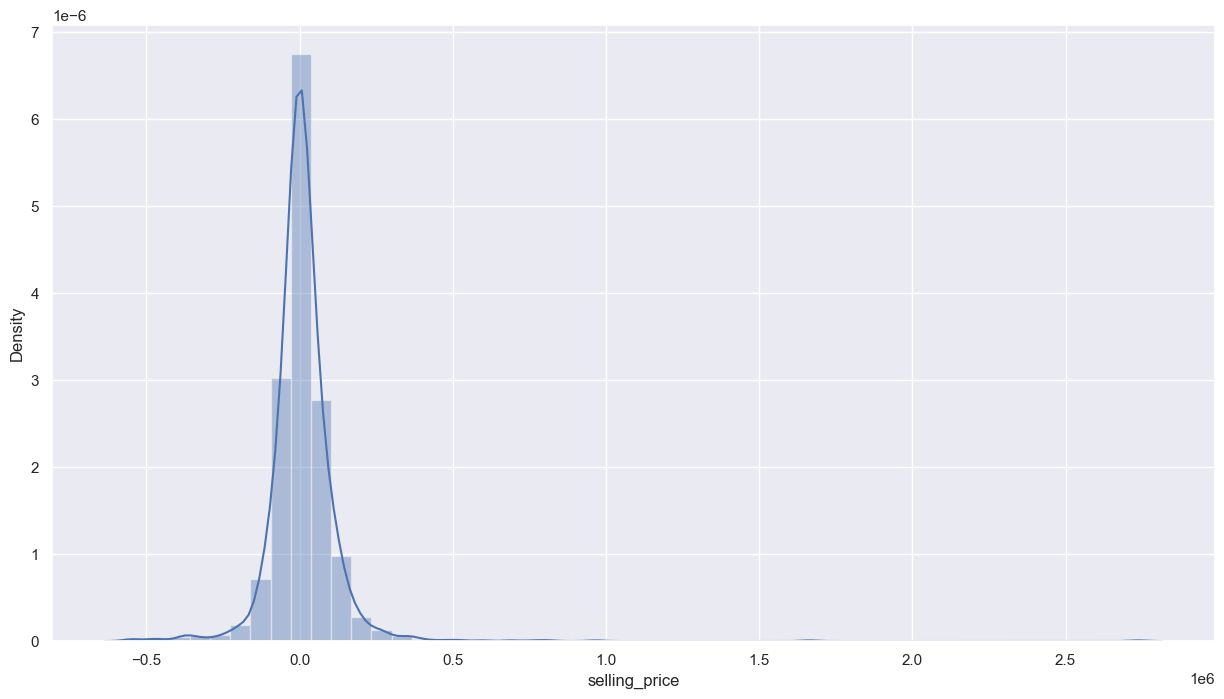

In [80]:
residual =np.expm1(y_test) - y_pred
sns.distplot(residual)

## Conclusion

- In this problem statement whave to predict the selling price of car base on some features
- First we have collected the dataset
- We cleaned the dataset
- We have done some exploratory data analysis on data set
- We done some visualization
- We done fetaure scalin and label encoding
- In the last we trainde multiple models on training dataset
- On the bases of performance of these models we have selected best one model out of them 
- In the end we  have done some prediction by using final model
